The objective of this assignment is to become familiar with the functionality of multilayer perceptron (MLP) neural networks, including their training, evaluation, and the application of regularization, optimization, and related techniques. <br>
The dataset used in this work is the MNIST dataset of handwritten English digits, consisting of 70,000 samples—60,000 for training and 10,000 for testing in its standard form.

# Modules

In [199]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Q1

Split the data into training, validation, and test sets. For validation, you should set aside 10% of the training dataset initially. Then, normalize the data.

## Load Data and Normalization

### train and validation set

In [200]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [201]:
# Load train data
train_dataset = datasets.MNIST(
    root='dataset/', train=True, transform=transform, download=True)

# 90% for training, 10% for validation
train_size = int(0.9 * len(train_dataset))
valid_size = len(train_dataset) - train_size

# Split the dataset
train_set, val_set = random_split(train_dataset, [train_size, valid_size])

print(f"""number of data samples in training set: {len(train_set)},
number of data samples in validation set: {len(val_set)},""")

number of data samples in training set: 54000,
number of data samples in validation set: 6000,


### test set

In [202]:
# Load test data
test_dataset = datasets.MNIST(
    root='dataset/', train=False, transform=transform, download=True)

print(f"number of data samples in test set: {len(test_dataset)}")

number of data samples in test set: 10000


In [203]:
# Create DataLoaders
train_loader = DataLoader(
    dataset=train_set, batch_size=128, shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset=val_set, batch_size=128,
                        shuffle=False, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=128, shuffle=False, pin_memory=True)

### Normalized and unnormalized data

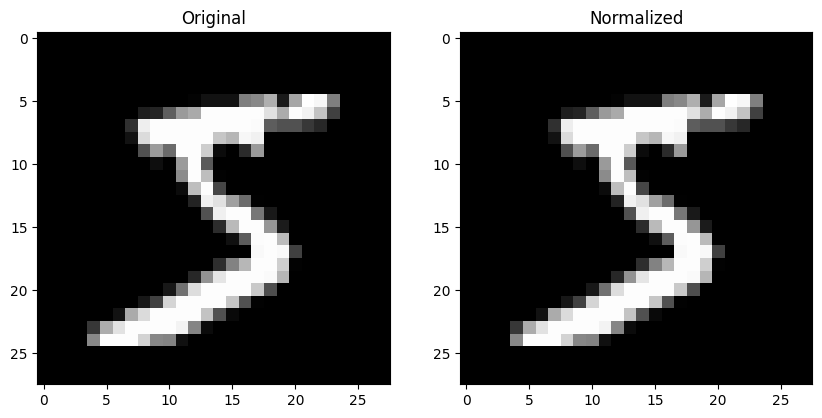

In [204]:
def denormalize(tensor, mean=0.1307, std=0.3081):
    return tensor * std + mean


# Compare images after and before normalization
idx = 0
normalized_img, label = train_dataset[idx]
unnormalized_img = denormalize(normalized_img)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(unnormalized_img.squeeze(), cmap='gray')
axes[0].set_title(f'Original')
axes[1].imshow(normalized_img.squeeze(), cmap='gray')
axes[1].set_title(f'Normalized')
plt.show()

# Q2

+ Use the optimization methods Gradient Descent (GD), Gradient Descent with Momentum, and Adam to train the network. <br>
+ For the training and validation data, plot the loss and accuracy curves over the training phase. <br>
+ To evaluate the performance of the network on the test data, use Precision, Recall, and F1-score metrics for each class. <br>

### Create a fully connected network (MLP)

In [205]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Initialization

In [206]:
seed = 42
torch.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

base_model = MLP(input_size=784, num_classes=10)

model_Ad = copy.deepcopy(base_model).to(device)
model_GD_mom = copy.deepcopy(base_model).to(device)
model_GD = copy.deepcopy(base_model).to(device)

criterion = nn.CrossEntropyLoss()
opt_Ad = optim.Adam(model_Ad.parameters(), lr=0.0008)
opt_GD_mom = optim.SGD(model_GD_mom.parameters(), lr=0.001, momentum=0.9)
opt_GD = optim.SGD(model_GD.parameters(), lr=0.01)

### Train and Evaluation functions

In [207]:
def eval_model(model, criterion, val_loader, device):
    """Evaluate model on val_loader. Returns (avg_loss, accuracy) for validation set"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device=device, non_blocking=True)
            y = y.to(device=device, non_blocking=True)
            x = x.reshape(x.shape[0], -1)

            logits = model(x)

            loss = criterion(logits, y)
            running_loss += loss.item() * y.shape[0]

            preds = logits.argmax(dim=1)

            correct += (preds == y).sum().item()
            total += y.shape[0]

    avg_loss = running_loss / total
    accuracy = correct / total

    return avg_loss, accuracy

In [208]:
def test_model(model, test_loader, device):
    """Evaluate model on test_loader. Returns (y_pred, y_true) for validation set"""
    model.eval()
    y_pred = []
    y_true = []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device=device, non_blocking=True)
            y = y.to(device=device, non_blocking=True)
            x = x.reshape(x.shape[0], -1)

            logits = model(x)
            preds = logits.argmax(dim=1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(y.cpu().numpy())

    return y_pred, y_true

In [209]:
def train_model(
    model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    device,
    num_epochs=10,
    scheduler=None,
    scheduler_step_per_epoch=True,
    print_every=1
):
    """
    Train model for num_epochs, evaluating on val_loader at end of each epoch.
    Returns dict with loss/accuracy history.
    """
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
    }
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device=device, non_blocking=True)
            y_batch = y_batch.to(device=device, non_blocking=True)
            x_batch = x_batch.reshape(x_batch.shape[0], -1)

            logits = model(x_batch)
            loss = criterion(logits, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * y_batch.shape[0]
            preds = logits.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.shape[0]

        train_loss = running_loss / total
        train_acc = correct / total

        val_loss, val_acc = eval_model(model, criterion, val_loader, device)

        if scheduler is not None:
            if scheduler_step_per_epoch:
                scheduler.step()

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if (epoch + 1) % print_every == 0:
            print(
                f"Epoch {epoch+1}/{num_epochs} | "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
            )

    return history

### Plot function

In [210]:
def plot_metric(train_metric, val_metric, label):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(train_metric, label=f"Train {label}")
    ax.plot(val_metric, label=f"Validation {label}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel(label)
    ax.set_title(f"Training and Validation {label}")
    ax.legend()
    plt.tight_layout()
    plt.show()

### Optimizers comparison

#### Optimizer: Adam

In [211]:
history_Adam = train_model(model_Ad, opt_Ad, criterion, train_loader,
                           val_loader, device, num_epochs=10)

Epoch 1/10 | Train Loss: 0.4367, Train Acc: 0.8777 | Val Loss: 0.2376, Val Acc: 0.9267
Epoch 2/10 | Train Loss: 0.1960, Train Acc: 0.9420 | Val Loss: 0.1780, Val Acc: 0.9458
Epoch 3/10 | Train Loss: 0.1468, Train Acc: 0.9566 | Val Loss: 0.1542, Val Acc: 0.9528
Epoch 4/10 | Train Loss: 0.1198, Train Acc: 0.9640 | Val Loss: 0.1326, Val Acc: 0.9588
Epoch 5/10 | Train Loss: 0.0975, Train Acc: 0.9701 | Val Loss: 0.1210, Val Acc: 0.9630
Epoch 6/10 | Train Loss: 0.0845, Train Acc: 0.9745 | Val Loss: 0.1129, Val Acc: 0.9625
Epoch 7/10 | Train Loss: 0.0735, Train Acc: 0.9778 | Val Loss: 0.1137, Val Acc: 0.9642
Epoch 8/10 | Train Loss: 0.0662, Train Acc: 0.9799 | Val Loss: 0.1090, Val Acc: 0.9652
Epoch 9/10 | Train Loss: 0.0579, Train Acc: 0.9824 | Val Loss: 0.1127, Val Acc: 0.9672
Epoch 10/10 | Train Loss: 0.0514, Train Acc: 0.9843 | Val Loss: 0.1076, Val Acc: 0.9665


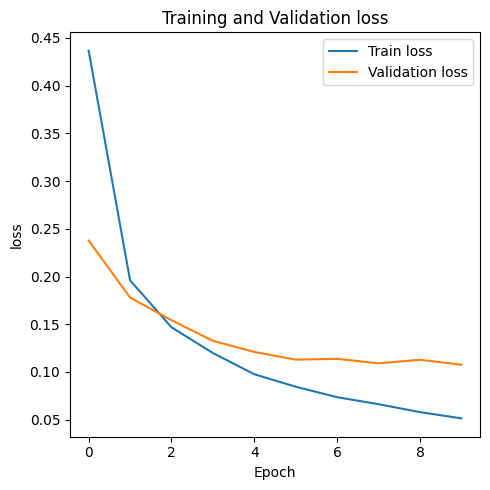

In [212]:
plot_metric(history_Adam["train_loss"], history_Adam["val_loss"], "loss")

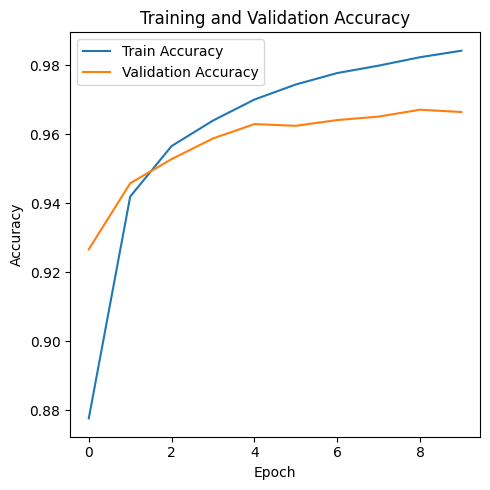

In [213]:
plot_metric(history_Adam['train_acc'], history_Adam['val_acc'], label='Accuracy')

In [214]:
y_pred, y_true = test_model(model_Ad, test_loader, device)

In [215]:
report_dict = classification_report(y_true, y_pred, output_dict=True)
df = pd.DataFrame(report_dict).transpose()
print(df)

              precision    recall  f1-score     support
0              0.968938  0.986735  0.977755    980.0000
1              0.991166  0.988546  0.989854   1135.0000
2              0.974659  0.968992  0.971817   1032.0000
3              0.962854  0.975248  0.969011   1010.0000
4              0.969512  0.971487  0.970498    982.0000
5              0.975113  0.966368  0.970721    892.0000
6              0.979123  0.979123  0.979123    958.0000
7              0.969142  0.977626  0.973366   1028.0000
8              0.969602  0.949692  0.959544    974.0000
9              0.966135  0.961348  0.963736   1009.0000
accuracy       0.972800  0.972800  0.972800      0.9728
macro avg      0.972624  0.972516  0.972543  10000.0000
weighted avg   0.972823  0.972800  0.972784  10000.0000
